In [50]:
# loading packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics, svm
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

In [5]:
# loading data
original_data = pd.read_csv('https://raw.githubusercontent.com/Kun97/FIFA20_DataAnalysis/main/data/players_20.csv')

In [6]:
# drop useless columns
drop1_columns = ['sofifa_id', 'player_url', 'long_name', 'player_tags', 'player_traits', 'real_face', 'nation_jersey_number', 'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until']
fixed1_Data = original_data.drop(drop1_columns, axis=1)

In [7]:
# drop position ability(duplicated and will affect the final result)
drop2_columns = fixed1_Data.columns[-26:]
fixed2_Data = fixed1_Data.drop(drop2_columns, axis=1)

In [8]:
# drop duplicated columns
drop3_columns = ['wage_eur', 'team_position', 'release_clause_eur', 'nation_position', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']
fixed3_Data = fixed2_Data.drop(drop3_columns, axis=1)

In [9]:
# split player_positions and choose the first position as primary position
new = fixed3_Data['player_positions'].str.split(',', expand=True)
fixed3_Data['Position'] = new[0]
position_data = fixed3_Data.drop('player_positions', axis=1)

In [10]:
# split work_Rate 
work_Rate = fixed3_Data['work_rate'].str.split('/', expand=True)
position_data['Attack_workrate'] = work_Rate[0]
position_data['Defend_workrate'] = work_Rate[1]
position_data = position_data.drop('work_rate', axis=1)

In [11]:
# narrow down positions: defender
defender = ['LCB', 'RCB', 'LB', 'RB', 'CB', 'RWB', 'LWB']
defender_data = position_data[position_data['Position'].isin(defender)]
defender_data['Positon_General'] = 'Defender'
defender_data.shape

(5938, 53)

In [12]:
# midfileder
midfileder = ['LCM', 'LM', 'RDM', 'CAM', 'RAM', 'RCM', 'CM', 'CDM', 'RM', 'LAM', 'LDM']
midfileder_data = position_data[position_data['Position'].isin(midfileder)]
midfileder_data['Positon_General'] = 'Midfileder'
midfileder_data.shape

(6862, 53)

In [13]:
# attacker
attacker = ['ST', 'CF', 'LW', 'RW']
attacker_data = position_data[position_data['Position'].isin(attacker)]
attacker_data['Positon_General'] = 'Attacker'
attacker_data.shape

(3442, 53)

In [14]:
# goal keeper
gk_data = position_data[position_data['Position'] == 'GK']
gk_data['Positon_General'] = 'GK'
gk_data.shape

(2036, 53)

In [15]:
# union all four group of data
general_data = pd.concat([defender_data, midfileder_data, attacker_data, gk_data])

In [16]:
# check missing data
general_data.isna().sum().sum()

0

In [17]:
# check duplicated data
general_data.duplicated().sum()

0

In [18]:
# numerlize categorical data
# Rate: low, medium, high: 0, 1, 2
# foot: left, right: 1, 0
# Positon_General: GK:0, Defender:1, Midfileder:2, Attacker:3 (One of the target)
general_data['Attack_workrate'] = general_data['Attack_workrate'].map({'Low':0, 'Medium':1, 'High':2})
general_data['Defend_workrate'] = general_data['Defend_workrate'].map({'Low':0, 'Medium':1, 'High':2})
general_data['Positon_General'] = general_data['Positon_General'].map({'GK':0, 'Defender':1, 'Midfileder':2, 'Attacker':3})

In [19]:
# one hot encoding for preferred_foot and body_type
onehot_data = pd.get_dummies(general_data[['preferred_foot', 'body_type']])

In [20]:
data = pd.concat([general_data, onehot_data], axis=1)
data = data.drop(['preferred_foot', 'body_type'], axis=1)
data = data.reset_index(drop=True)

# Regression 

## Data

In [21]:
num_col_all = data.describe().columns.tolist()
num_col_all_new = num_col_all[:-13] 

In [22]:
scaler = StandardScaler()
scaler.fit(data[num_col_all_new])
X_std = scaler.transform(data[num_col_all_new])

In [23]:
new_data = pd.DataFrame(X_std, columns=num_col_all_new)
dummy_data = data.iloc[:,-13:]
new_data_final = pd.concat([new_data,dummy_data ], axis=1)

In [24]:
y = new_data_final['value_eur']
X = new_data_final[num_col_all].drop('value_eur',axis=1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=1)

## Linear Regression

In [26]:
lr_all=LinearRegression()  
lr_all.fit(X_train, y_train) 
y_pred1=lr_all.predict(X_test)

In [27]:
# coefficient of intercept
lr_all.intercept_

3.0685796236685925

In [28]:
# Return the coefficient of determination R^2 of the prediction.
lr_all.score(X_test, y_test)

0.6335495134576389

In [29]:
# other evaluation metrics
print('R^2:',metrics.r2_score(y_test, y_pred1))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_pred1))*(len(y_test)-1)/(len(y_test)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_pred1))
print('MSE:',metrics.mean_squared_error(y_test, y_pred1))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_pred1)))

R^2: 0.6335495134576389
Adjusted R^2: 0.629699959876195
MAE: 0.3397156144918145
MSE: 0.3872659585016101
RMSE: 0.6223069648506355


In [30]:
#Converting the coefficient values to a dataframe
lr_coeffcients = pd.DataFrame([X_train.columns,lr_all.coef_]).T
lr_coeffcients = lr_coeffcients.rename(columns={0: 'Attribute', 1: 'Coefficients'}) #put into dataframe
lr_coeffcients #print out

Attribute Coefficients
0                             age    -0.340396
1                       height_cm   0.00762294
2                       weight_kg   0.00561926
3                         overall     0.653168
4                       potential   -0.0703587
5        international_reputation     0.402374
6                       weak_foot     0.003183
7                     skill_moves    0.0197562
8              attacking_crossing   -0.0462523
9             attacking_finishing    0.0645732
10     attacking_heading_accuracy    -0.030792
11        attacking_short_passing   -0.0369795
12              attacking_volleys    0.0123245
13                skill_dribbling   -0.0306684
14                    skill_curve    0.0181427
15              skill_fk_accuracy    0.0140624
16             skill_long_passing    0.0260612
17             skill_ball_control    -0.102667
18          movement_acceleration   -0.0345852
19          movement_sprint_speed    0.0291537
20               movement_agility   -0.0324575
21             movement_reactions    0.0668625
22               movement_balance    0.0337472
23               power_shot_power    -0.054978
24                  power_jumping   -0.0130553
25                  power_stamina    0.0470014
26                 power_strength   -0.0176541
27               power_long_shots   -0.0342202
28           mentality_aggression   -0.0163731
29        mentality_interceptions   -0.0194865
30          mentality_positioning    0.0373319
31               mentality_vision    0.0425518
32            mentality_penalties   -0.0334924
33            mentality_composure  0.000120603
34              defending_marking    -0.013742
35      defending_standing_tackle    0.0269463
36       defending_sliding_tackle   -0.0136003
37             goalkeeping_diving   -0.0553458
38           goalkeeping_handling   -0.0156578
39            goalkeeping_kicking    0.0344287
40        goalkeeping_positioning   -0.0274683
41           goalkeeping_reflexes    -0.015994
42                Attack_workrate   0.00766938
43                Defend_workrate    0.0208292
44                Positon_General    0.0022821
45            preferred_foot_Left  0.000511688
46           preferred_foot_Right -0.000511688
47            body_type_Akinfenwa -6.73073e-16
48           body_type_C. Ronaldo  2.08167e-17
49             body_type_Courtois     0.195579
50                 body_type_Lean     -3.07625
51                body_type_Messi            0
52               body_type_Neymar      9.03555
53               body_type_Normal     -3.08119
54  body_type_PLAYER_BODY_TYPE_25            0
55              body_type_Shaqiri            0
56               body_type_Stocky     -3.07369

## Lasso Regression

In [31]:
lasso=Lasso()
param_grid = {'alpha':np.arange(0.01,0.1,0.01)}

grid = GridSearchCV(lasso, param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])},
             scoring='r2')

In [32]:
print('The accuracy score of lasso regression: {}'.format(grid.best_score_))
print('The best parameter of lasso regression: {}'. format(grid.best_params_))

The accuracy score of lasso regression: 0.601463982334756
The best parameter of lasso regression: {'alpha': 0.01}


In [33]:
best_lasso = grid.best_estimator_

In [34]:
#Converting the coefficient values to a dataframe
lasso_coeffcients = pd.DataFrame([X_train.columns,best_lasso.coef_]).T
lasso_coeffcients = lasso_coeffcients.rename(columns={0: 'Attribute', 1: 'Coefficients'}) #put into dataframe
lasso_coeffcients #print out

Attribute Coefficients
0                             age    -0.276598
1                       height_cm            0
2                       weight_kg           -0
3                         overall     0.517952
4                       potential            0
5        international_reputation     0.403157
6                       weak_foot            0
7                     skill_moves            0
8              attacking_crossing           -0
9             attacking_finishing            0
10     attacking_heading_accuracy   -0.0139849
11        attacking_short_passing           -0
12              attacking_volleys            0
13                skill_dribbling           -0
14                    skill_curve           -0
15              skill_fk_accuracy           -0
16             skill_long_passing           -0
17             skill_ball_control           -0
18          movement_acceleration            0
19          movement_sprint_speed            0
20               movement_agility           -0
21             movement_reactions    0.0557051
22               movement_balance            0
23               power_shot_power   -0.0124133
24                  power_jumping  -0.00215422
25                  power_stamina    0.0121054
26                 power_strength           -0
27               power_long_shots           -0
28           mentality_aggression  -0.00981891
29        mentality_interceptions           -0
30          mentality_positioning            0
31               mentality_vision    0.0101571
32            mentality_penalties           -0
33            mentality_composure            0
34              defending_marking  -0.00421088
35      defending_standing_tackle           -0
36       defending_sliding_tackle  -0.00887336
37             goalkeeping_diving            0
38           goalkeeping_handling            0
39            goalkeeping_kicking            0
40        goalkeeping_positioning            0
41           goalkeeping_reflexes            0
42                Attack_workrate   0.00140594
43                Defend_workrate   0.00645715
44                Positon_General            0
45            preferred_foot_Left           -0
46           preferred_foot_Right            0
47            body_type_Akinfenwa            0
48           body_type_C. Ronaldo            0
49             body_type_Courtois            0
50                 body_type_Lean            0
51                body_type_Messi            0
52               body_type_Neymar            0
53               body_type_Normal           -0
54  body_type_PLAYER_BODY_TYPE_25            0
55              body_type_Shaqiri            0
56               body_type_Stocky            0

In [35]:
names = lasso_coeffcients.Attribute.tolist()

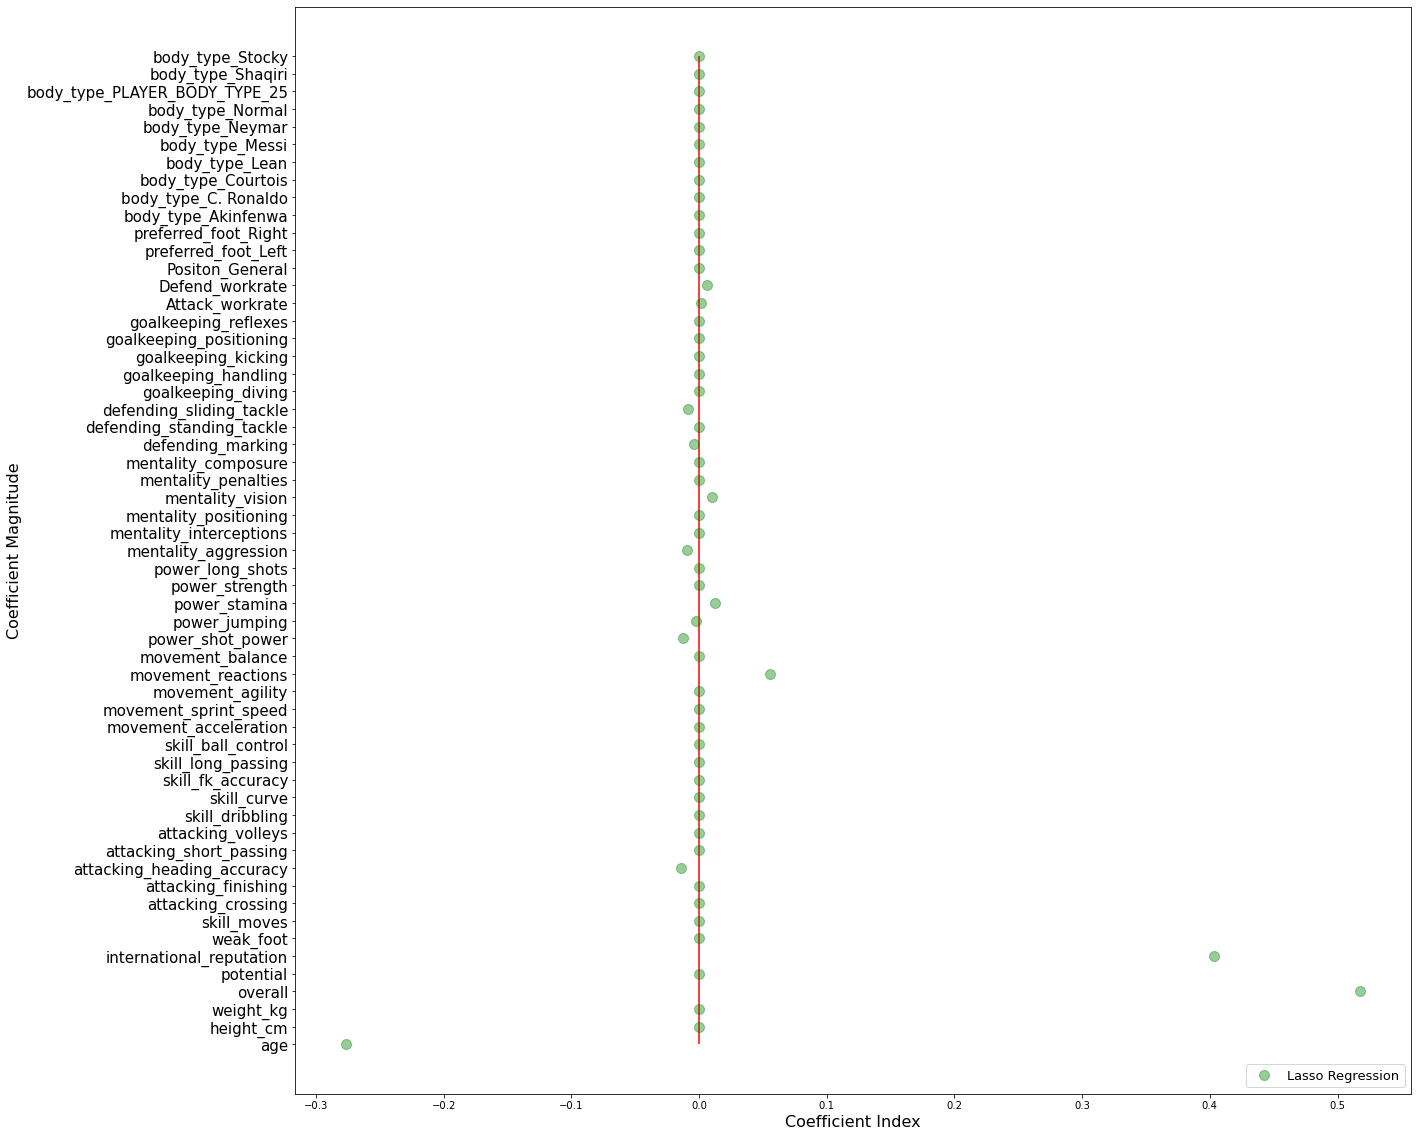

In [36]:
plt.figure(figsize=(20,20))
plt.plot(best_lasso.coef_,names,alpha=0.4,linestyle='none',marker='o',markersize=10,color='green',label='Lasso Regression')
plt.yticks(fontsize=15)
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.vlines(0,ymin = 0,ymax=56,color='r')
plt.show()

## Random Forest Regression

In [37]:
y = data['value_eur']/10000
X = data[num_col_all].drop('value_eur',axis=1)

In [38]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y,test_size=0.3, random_state=1)

In [39]:
# Number of trees in random forest
n_estimators =[int(x) for x in np.linspace(start = 50, stop = 150, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [40]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42,scoring='r2', n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train1, y_train1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.5min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150]},
                   random_state=42, scoring='r2', verbose=2)

In [41]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [42]:
# Return the coefficient of determination R^2 of the prediction.
rf_random.best_score_

0.9659067297418346

In [43]:
best_rf = rf_random.best_estimator_
rf_pred = best_rf.predict(X_test1)

In [47]:
fi_df = pd.DataFrame(rf_random.best_estimator_.feature_importances_, columns=['importances'])
fi_df['feature_name'] =  X_train.columns
fi_df.sort_values(by=['importances'], ascending=False, inplace=True)

In [48]:
fi_df_new = fi_df[fi_df['importances']>0.00115]
fi_df_new

importances           feature_name
3      0.839891                overall
4      0.097325              potential
0      0.021938                    age
21     0.005473     movement_reactions
30     0.002764  mentality_positioning
9      0.002512    attacking_finishing
17     0.002250     skill_ball_control
32     0.002221    mentality_penalties
13     0.001739        skill_dribbling
12     0.001524      attacking_volleys
31     0.001387       mentality_vision
19     0.001153  movement_sprint_speed

<Figure size 1440x720 with 0 Axes>

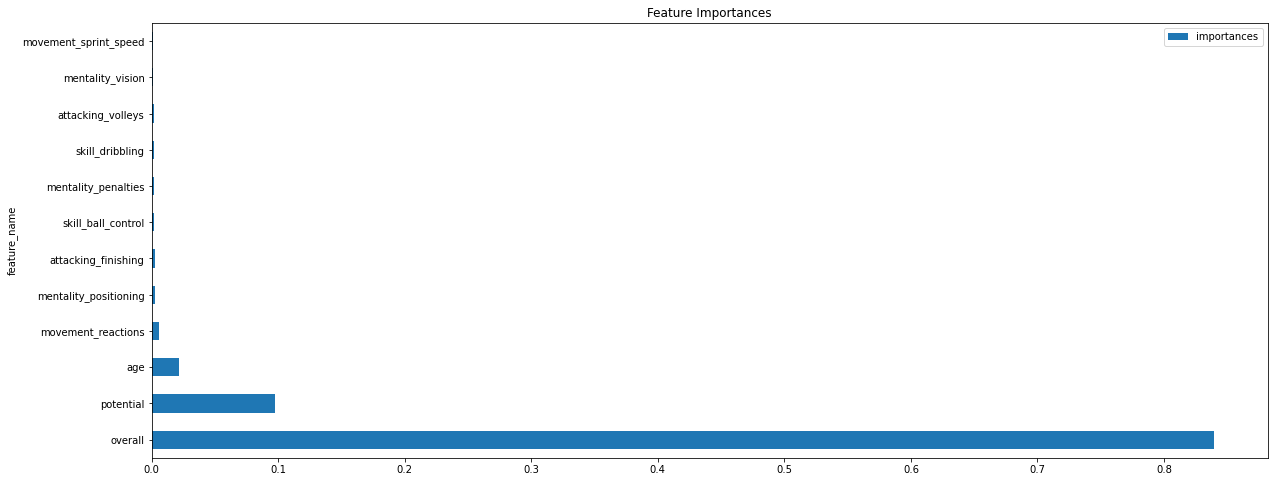

In [49]:
plt.figure(figsize=(20,10))
fi_df_new.plot.barh(x='feature_name', 
               y ='importances',
               figsize=(20,8), 
               title='Feature Importances', 
               fontsize=10)
plt.show()

In [51]:
print('R^2:',metrics.r2_score(y_test1, rf_pred))
print('MAE:',metrics.mean_absolute_error(y_test1,rf_pred))
print('MSE:',metrics.mean_squared_error(y_test1, rf_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test1, rf_pred)))

R^2: 0.969323584768083
MAE: 18.782924872355945
MSE: 10113.373214815829
RMSE: 100.56526843207763


In [52]:
rmse = np.sqrt(metrics.mean_squared_error(y_test1, rf_pred))

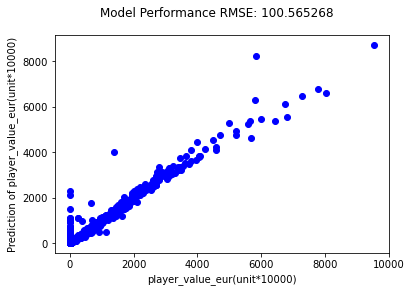

In [53]:
plt.plot(y_test1, rf_pred, 'bo')
plt.xlabel('player_value_eur(unit*10000)')
plt.ylabel('Prediction of player_value_eur(unit*10000)')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

# Classification

## Data

In [54]:
#train, test set split
#training_list is required for classifier function 
training_list = data.iloc[:,10:].columns.tolist()

In [55]:
training_list.append('height_cm')
training_list.append('weight_kg')
training_list.append('age')
training_list.remove('Position')

In [56]:
training_set = data[training_list]
training_set = training_set.reset_index(drop = True)

In [57]:
#train, test set is required for classifier function 
Y = training_set['Positon_General']
X = training_set.drop('Positon_General', axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state = 1)

## Decision Tree

In [58]:
#define tree classifier
clf = DecisionTreeClassifier(random_state=1)
clf.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=1)

In [61]:
#do grid search
param_grid = {'criterion':['gini','entropy'],
             'min_samples_split':[2,10,20],
              'max_depth':[5,10,20,25,30],
              'min_samples_leaf':[1,5,10],
              'max_leaf_nodes':[2,5,10,20]}
grid = GridSearchCV(clf, param_grid, cv = 10, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, Y_train)
print(f"Accuracy after hyperparameter tuning:{round(grid.best_score_*100)}%")
print("Best parameters for decision tree algorithm are:")
for hps,values in grid.best_params_.items():
    print(f"{hps}:{values}")

Accuracy after hyperparameter tuning:84%
Best parameters for decision tree algorithm are:
criterion:gini
max_depth:10
max_leaf_nodes:20
min_samples_leaf:1
min_samples_split:2


In [66]:
def DT_classifier(criterion='gini', max_depth=10, max_leaf_nodes=30, min_samples_split=2):
    #build model with hyperparameter initialized
    dt_clf = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, max_leaf_nodes = max_leaf_nodes, min_samples_split =min_samples_split)
    dt_clf.fit(X_train, Y_train)
    dt_clf_pred = dt_clf.predict(X_test)
    #estimate the model
    acc = round(metrics.accuracy_score(Y_test, dt_clf_pred),2)
    f1 = round(metrics.f1_score(Y_test, dt_clf_pred, average = 'macro'),2)
    recall = round(metrics.recall_score(Y_test, dt_clf_pred, average = 'micro'),2)
    precision = round(metrics.precision_score(Y_test, dt_clf_pred, average = 'micro'),2)
    estimator_df = pd.DataFrame({'metrics':['accuracy','f1 score','recall','precision'],
                            'value':[acc,f1,recall,precision]})
    return estimator_df, dt_clf

In [67]:
df, clf = DT_classifier()
df

metrics  value
0   accuracy   0.86
1   f1 score   0.88
2     recall   0.86
3  precision   0.86

## SVM

In [68]:
#web app hyperparameter tuning
def SVM_classifier(max_iteration = 100000,cost = 0.5):
    #build model with hyperparameter initialized
    sc = StandardScaler()
    svc = svm.LinearSVC(max_iter=max_iteration, C = cost, random_state=1,
                       multi_class='crammer_singer')
    svc_pipe = make_pipeline(sc, svc)
    svc_pipe.fit(X_train,Y_train)
    svc_pred = svc_pipe.predict(X_test)
    #estimate the model
    acc = round(metrics.accuracy_score(Y_test, svc_pred),2)
    f1 = round(metrics.f1_score(Y_test, svc_pred, average = 'macro'),2)
    recall = round(metrics.recall_score(Y_test, svc_pred, average = 'micro'),2)
    precision = round(metrics.precision_score(Y_test, svc_pred, average = 'micro'),2)
    estimator_df = pd.DataFrame({'metrics':['accuracy','f1 score','recall','precision'],
                            'value':[acc,f1,recall,precision]})
    #model inference
    columns = list(training_list)
    columns.remove('Positon_General')
    coef_df = pd.DataFrame(svc_pipe.steps[-1][1].coef_, columns=columns, index = ['GK','Defender','Midfileder','Attacker'])
    return estimator_df, svc_pipe, coef_df

In [69]:
estimator_df, svc_pipe, coef_df = SVM_classifier()

In [70]:
estimator_df

metrics  value
0   accuracy   0.90
1   f1 score   0.91
2     recall   0.90
3  precision   0.90

In [71]:
coef_df

international_reputation  weak_foot  skill_moves  \
GK                          0.002274   0.000717    -0.059751   
Defender                    0.004330   0.042198     0.045950   
Midfileder                 -0.039637   0.011650    -0.011380   
Attacker                    0.033033  -0.054565     0.025180   

            attacking_crossing  attacking_finishing  \
GK                   -0.050870            -0.073062   
Defender              0.919828            -0.777201   
Midfileder           -0.177898            -0.206893   
Attacker             -0.691060             1.057156   

            attacking_heading_accuracy  attacking_short_passing  \
GK                           -0.089865                -0.044908   
Defender                      0.433013                -0.878883   
Midfileder                   -0.381599                 0.742597   
Attacker                      0.038451                 0.181194   

            attacking_volleys  skill_dribbling  skill_curve  ...  \
GK                  -0.063288        -0.055752    -0.052152  ...   
Defender            -0.149535        -0.175661     0.293558  ...   
Midfileder          -0.048673         0.285307    -0.143045  ...   
Attacker             0.261496        -0.053894    -0.098360  ...   

            body_type_Lean  body_type_Messi  body_type_Neymar  \
GK               -0.003642              0.0          0.000073   
Defender          0.014478              0.0          0.004797   
Midfileder        0.000633              0.0         -0.010384   
Attacker         -0.011469              0.0          0.005515   

            body_type_Normal  body_type_PLAYER_BODY_TYPE_25  \
GK                 -0.004896                            0.0   
Defender            0.002318                            0.0   
Midfileder          0.000342                            0.0   
Attacker            0.002237                            0.0   

            body_type_Shaqiri  body_type_Stocky  height_cm  weight_kg  \
GK                        0.0          0.017894   0.019761   0.029844   
Defender                  0.0         -0.035146   0.083146  -0.030365   
Midfileder                0.0         -0.001240  -0.012402  -0.026572   
Attacker                  0.0          0.018492  -0.090505   0.027093   

                 age  
GK          0.054677  
Defender    0.226261  
Midfileder -0.081769  
Attacker   -0.199169  

[4 rows x 54 columns]

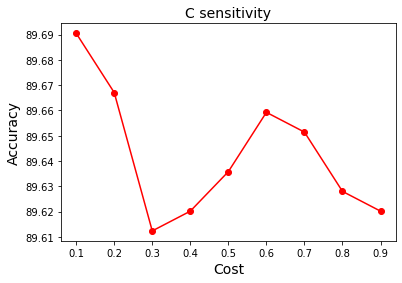

In [73]:
#hyperparameter tuning C plot
max_iteration = 100000
cost = 0.5
sc = StandardScaler()
svc = svm.LinearSVC(max_iter=max_iteration, C = cost, random_state=1,
                        multi_class='crammer_singer')
svc_pipe = make_pipeline(sc, svc)
svc_pipe.fit(X_train,Y_train)
#manually tune C
#initialize C
C = np.arange(0.1,1,0.1)
accuracy_result_svm=[]
#for each C, construct model and calculate accuracy
for cost in C:
    svc = svm.LinearSVC(max_iter=max_iteration, C = cost, random_state=1,
                       multi_class='crammer_singer')
    svc_pipe = make_pipeline(sc, svc)
    svc_pipe.fit(X_train,Y_train)
    #calculate cross validation score
    acc = cross_val_score(svc_pipe, X_train, Y_train, cv=3).mean()*100
    accuracy_result_svm.append(acc)
plt.plot(C, accuracy_result_svm, color='red', marker='o')
plt.title('C sensitivity', fontsize=14)
plt.xlabel('Cost', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

## Random Forest

In [74]:
rf_par = {'n_estimators':[10,50,100],
          'max_features':[1,2,3,5],
          'max_depth':[5,25,50],
          'criterion':['gini','entropy']}

random_forest_grid = GridSearchCV(RandomForestClassifier(),
                                  param_grid=rf_par,
                                  cv=3,
                                  n_jobs=-1)
random_forest_grid.fit(X_train,Y_train)
print("Best parameters for Random forest are:")
for index, values in random_forest_grid.best_params_.items():
    print(f"{index}:{values}")

Best parameters for Random forest are:
criterion:entropy
max_depth:50
max_features:5
n_estimators:100


In [75]:
#web app hyperparameter tuning
def Random_Forest_classifier(criterion = 'entropy',max_depth = 5,max_features = 5,n_estimators = 100):
    #build model with hyperparameter initialized
    RF_clf = RandomForestClassifier(criterion = criterion, max_depth = max_depth,
                                               n_estimators=n_estimators, max_features=max_features, random_state=16)
    RF_clf.fit(X_train, Y_train)
    RF_clf_pred = RF_clf.predict(X_test)

    #estimate the model
    acc = round(metrics.accuracy_score(Y_test, RF_clf_pred),2)
    f1 = round(metrics.f1_score(Y_test, RF_clf_pred, average = 'macro'),2)
    recall = round(metrics.recall_score(Y_test, RF_clf_pred, average = 'micro'),2)
    precision = round(metrics.precision_score(Y_test, RF_clf_pred, average = 'micro'),2)
    estimator_df = pd.DataFrame({'metrics':['accuracy','f1 score','recall','precision'],
                            'value':[acc,f1,recall,precision]})
    #model inference
    columns = list(training_list)
    columns.remove('Positon_General')
    coef_df = pd.DataFrame({'Feature':columns,'Importance': RF_clf.feature_importances_}).sort_values('Importance', ascending= False)
    return estimator_df, RF_clf, coef_df

In [76]:
estimator_df, RF_clf, coef_df = Random_Forest_classifier()

In [77]:
estimator_df

metrics  value
0   accuracy   0.86
1   f1 score   0.88
2     recall   0.86
3  precision   0.86

In [78]:
coef_df

Feature  Importance
31       defending_sliding_tackle    0.107119
30      defending_standing_tackle    0.092826
24        mentality_interceptions    0.064876
4             attacking_finishing    0.061620
33           goalkeeping_handling    0.058663
29              defending_marking    0.054483
5      attacking_heading_accuracy    0.050137
25          mentality_positioning    0.047514
7               attacking_volleys    0.044910
2                     skill_moves    0.041788
34            goalkeeping_kicking    0.038642
22               power_long_shots    0.029138
36           goalkeeping_reflexes    0.028991
11             skill_long_passing    0.027836
32             goalkeeping_diving    0.025623
8                 skill_dribbling    0.025391
35        goalkeeping_positioning    0.024201
27            mentality_penalties    0.023895
26               mentality_vision    0.023772
9                     skill_curve    0.020100
6         attacking_short_passing    0.017593
18               power_shot_power    0.016073
10              skill_fk_accuracy    0.012584
3              attacking_crossing    0.010503
23           mentality_aggression    0.010495
12             skill_ball_control    0.009014
21                 power_strength    0.004730
14          movement_sprint_speed    0.004175
20                  power_stamina    0.003963
19                  power_jumping    0.003313
51                      height_cm    0.002871
15               movement_agility    0.002805
17               movement_balance    0.002754
52                      weight_kg    0.001518
37                Attack_workrate    0.001164
13          movement_acceleration    0.001050
16             movement_reactions    0.000926
40           preferred_foot_Right    0.000679
53                            age    0.000671
28            mentality_composure    0.000600
38                Defend_workrate    0.000593
39            preferred_foot_Left    0.000256
44                 body_type_Lean    0.000058
1                       weak_foot    0.000040
0        international_reputation    0.000033
47               body_type_Normal    0.000015
41            body_type_Akinfenwa    0.000000
42           body_type_C. Ronaldo    0.000000
43             body_type_Courtois    0.000000
45                body_type_Messi    0.000000
46               body_type_Neymar    0.000000
48  body_type_PLAYER_BODY_TYPE_25    0.000000
49              body_type_Shaqiri    0.000000
50               body_type_Stocky    0.000000

# Recommender System

## Feature engineering

In [79]:
# find out all columns we need for pca, clustering and recommender system
remove_columns = ['short_name', 'dob', 'nationality', 'club', 'preferred_foot', 'body_type', 'Position', 'Attack_workrate', 'Defend_workrate', 'Positon_General']
va_columns = list(set(data.columns) - set(remove_columns))
clustering_data = data[va_columns]

In [80]:
# standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler_data = pd.DataFrame(scaler.fit_transform(clustering_data), columns=clustering_data.columns)

## Building system

In [81]:
# PCA Reduce the dimension to 2 
from sklearn.decomposition import PCA
recommender_pca = PCA(n_components=2)
recommender_data = pd.DataFrame(recommender_pca.fit_transform(scaler_data), columns=['PC1', 'PC2'])

# add name
recommender_data['Name'] = list(data['short_name'])

In [82]:
def recommender_system(name, num_players):
  try:
    cha = list([name])
    num = int(num_players)
  except:
    return 'Check your inputs!'

  length_check = (len(cha) == 1)
  exist_check = (recommender_data['Name'] == name).any()

  if length_check & exist_check:
      PC1 = recommender_data[recommender_data['Name'] == name]['PC1'].values[0]
      PC2 = recommender_data[recommender_data['Name'] == name]['PC2'].values[0]

      result = recommender_data.apply(lambda row: np.sqrt((row.PC1 - PC1)**2 + (row.PC2 - PC2)**2), axis=1).sort_values().iloc[:num+1]
    
    
  else:
    return 'Check your inputs!'
  
  return data.iloc[result.index[1:]][['short_name', 'Position', 'overall', 'value_eur']].rename({'short_name':'Name', 'Position':'Position', 'overall':'Overall Score', 'value_eur':'Value'}, axis='columns').reset_index(drop=True)

## System Testing

In [83]:
recommender_system('L. Messi',5)

Name Position  Overall Score      Value
0          Neymar Jr       LW             92  105500000
1          E. Hazard       LW             91   90000000
2           M. Salah       RW             90   80500000
3  Cristiano Ronaldo       ST             93   58500000
4          P. Dybala      CAM             88   76500000

In [84]:
recommender_system('Cristiano Ronaldo',5)

Name Position  Overall Score     Value
0     A. Griezmann       CF             89  69000000
1        L. Modrić       CM             90  45000000
2     K. De Bruyne      CAM             91  90000000
3         M. Salah       RW             90  80500000
4  Bruno Fernandes      CAM             85  49000000

In [85]:
recommender_system('J. Oblak',5)

Name Position  Overall Score     Value
0  M. ter Stegen       GK             90  67500000
1        Alisson       GK             89  58000000
2       M. Neuer       GK             88  32000000
3      N. Guzmán       GK             79   7000000
4         De Gea       GK             89  56000000

In [86]:
recommender_system('V. van Dijk',5)

Name Position  Overall Score     Value
0       M. Hummels       CB             87  41000000
1       A. Laporte       CB             87  56500000
2            Piqué       CB             88  38000000
3  T. Alderweireld       CB             87  41000000
4    J. Vertonghen       CB             87  32500000

In [87]:
recommender_system('K. De Bruyne',5)

Name Position  Overall Score     Value
0       A. Griezmann       CF             89  69000000
1          L. Modrić       CM             90  45000000
2  Cristiano Ronaldo       ST             93  58500000
3            Marcelo       LB             85  28000000
4             Thiago       CM             87  50000000

# Clustering

## Choosing best pca for k-means

In [88]:
# check number of pca we need
# According to ISLR, "There are at most min(n - 1; p) principal components" where n is the number of rows, 18278 and p is the number of cols, 55.
min(len(scaler_data)-1, len(va_columns))

55

In [89]:
clutering_pca = PCA(n_components=55)
clutering_data = pd.DataFrame(clutering_pca.fit_transform(scaler_data))

In [90]:
# account for 100% variance of original data
sum(clutering_pca.explained_variance_ratio_)

1.0

Text(0, 0.5, 'Proportion Variance Explained')

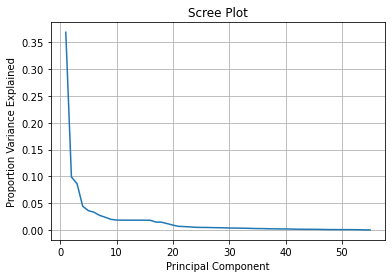

In [91]:
from matplotlib import pyplot as plt
plt.figure()
explained_var = clutering_pca.explained_variance_ratio_
plt.plot(np.arange(1, len(explained_var)+1), explained_var)
plt.grid(True)
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Proportion Variance Explained")

Text(0, 0.5, 'Cumulative Sum of Variance Explained')

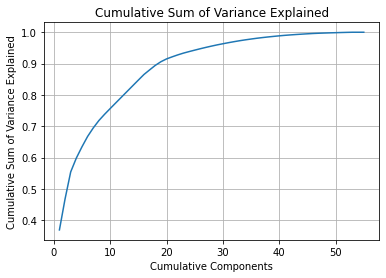

In [92]:
cum_sum = np.cumsum(explained_var)
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), cum_sum)
plt.grid(True)
plt.title("Cumulative Sum of Variance Explained")
plt.xlabel("Cumulative Components")
plt.ylabel("Cumulative Sum of Variance Explained")

In [93]:
# I choose 30 pca

## K-Means

In [94]:
# best pca: 30
kmeans_pca = PCA(n_components=30)
kmeans_data = kmeans_pca.fit_transform(scaler_data)


In [95]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
def max_silhouette(k):
  score = []
  for i in range(3):
    km = KMeans(n_clusters=k, random_state=int(np.random.randint(100, size=1)))
    pred = km.fit_predict(kmeans_data)
    score.append(silhouette_score(kmeans_data, pred))
  
  return max(score)


In [96]:
result = []
for i in range(2, 7):
  result.append(max_silhouette(i))

Text(0.5, 1.0, 'Silhouette Score vs Number of Clusters')

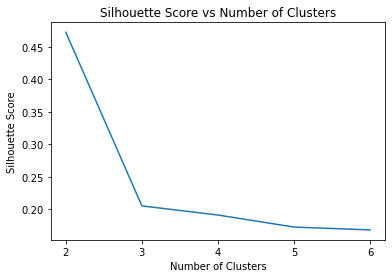

In [97]:
plt.plot(range(2,7), result)
plt.xticks(range(2,7))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')

In [98]:
# best k for kmeans is 2

### Best Clustering Result

In [99]:
final_km = KMeans(n_clusters=2)
final_pred = final_km.fit_predict(scaler_data)

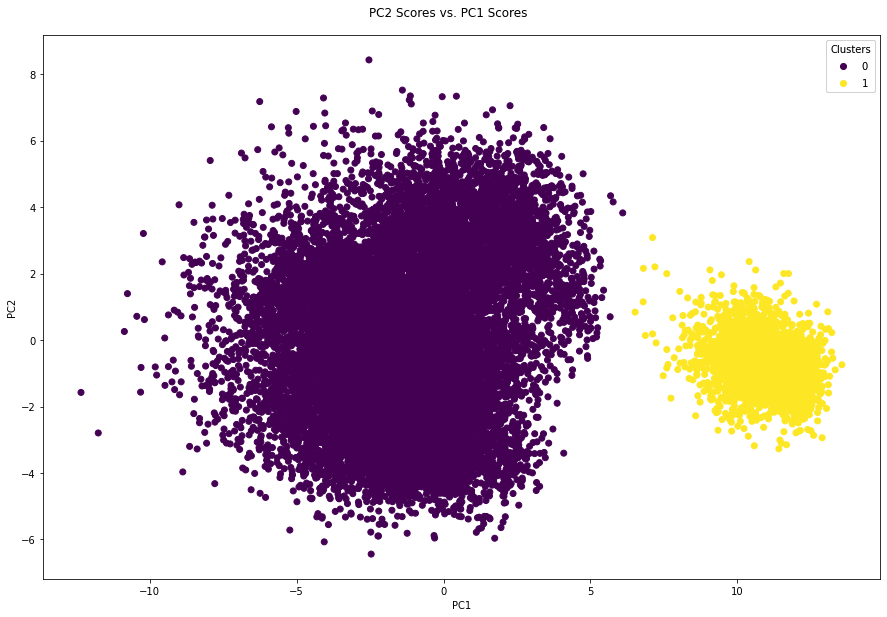

In [100]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
scatter = ax.scatter(recommender_data.PC1, recommender_data.PC2, c=final_pred)
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend)
fig.suptitle("PC2 Scores vs. PC1 Scores", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")  
plt.show()